# This script attempts to predict who will survive on the titanic

### Read and clean data

In [116]:
import pandas as pd

df_train = pd.read_csv('/Users/melgazar9/Downloads/titanic_train.csv')
df_test = pd.read_csv('/Users/melgazar9/Downloads/titanic_test.csv')

In [117]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [118]:
# Reorder df_train to make Survived the last column
df_train = df_train[['PassengerId', 'Pclass', 'Name', 'Sex',
                    'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
                    'Embarked', 'Survived']]

# Assign X (data) and y (target)
X = df_train.drop('Survived', axis=1)
y = df_train.Survived

### Find columns in the dataframe that have null values

In [119]:
df_train.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
Survived       False
dtype: bool

##### Age, Cabin, and Embarked have null values so I will fill the null values with something reasonable

In [120]:
X['Age'].value_counts(sort=True, ascending=False).tail()

55.50    1
70.50    1
66.00    1
23.50    1
0.42     1
Name: Age, dtype: int64

##### There are some decimal values that should not be decimals for age. 

In [121]:
X['Age'].loc[X['Age'] < 1]

78     0.83
305    0.92
469    0.75
644    0.75
755    0.67
803    0.42
831    0.83
Name: Age, dtype: float64

In [122]:
import math

def round_down(n):
    return float(math.floor(n / 1.0)) * 1

X['Age'] = X['Age'].apply(lambda x: round_down(x))
X['Age'].loc[X['Age'] < 1]

78     0.0
305    0.0
469    0.0
644    0.0
755    0.0
803    0.0
831    0.0
Name: Age, dtype: float64

In [123]:
X['Age'] = X['Age'].fillna(X['Age'].median())

##### Fill NaN Values in Cabin

In [124]:
X['Cabin'].isnull().sum()

687

##### Since there are lots of missing values, it may be a good idea to fill these values with a value that doesn't exist in the entire column, i.e. -1

In [125]:
X['Cabin'].loc[X['Cabin']==-1]

Series([], Name: Cabin, dtype: object)

In [126]:
X['Cabin'] = X['Cabin'].fillna(-1)
len(X['Cabin'].loc[X['Cabin']==-1]) # should be 687

687

##### Fill NaN values in Embarked

In [127]:
X['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [128]:
X['Embarked'].isnull().sum()

2

In [129]:
# We can fill NaN values in Embarked with most frequent since there are only 2 null values

X['Embarked'].fillna(X['Embarked'].value_counts().idxmax(), inplace=True)
X['Embarked'].isnull().sum() # should be 0

0

### We need to do this same thing on df_test so we can make valid predictions

In [130]:
df_test['Age'] = df_test['Age'].apply(lambda x: round_down(x))
df_test['Age'].loc[df_test['Age'] < 1]

df_test['Age'] = df_test['Age'].fillna(X['Age'].median())

In [131]:
df_test['Age'].isnull().sum()

0

In [132]:
df_test['Cabin'].isnull().sum()

327

In [133]:
df_test['Cabin'] = df_test['Cabin'].fillna(-1)

In [134]:
df_test['Embarked'].isnull().sum() #  no null values in the unseen test set so nothing to worry about

0

### Find numerical and non-numerical columns to one-hot encode or categorize each column

In [135]:
numerical_cols = list(df_train.dtypes[df_train.dtypes != 'object'].index)
numerical_cols

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']

In [136]:
non_numerical_cols = [set(X.columns) - set(numerical_cols)]
non_numerical_cols

[{'Cabin', 'Embarked', 'Name', 'Sex', 'Ticket'}]

##### One-Hot Encode X['Age'], X['Embarked'],  df_test['Age'], and df_test['Embarked']

In [137]:
X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Sex', 'Embarked'], drop_first=True)

### Categorize the rest of the columns 

##### Drop name column since every value is unique - can contribute to overfitting

In [138]:
for field_name, dtype in X.dtypes[X.dtypes == 'object'].items():
    print(field_name)
    X[field_name] = pd.Series(pd.Categorical(X[field_name]).codes)
    
for field_name, dtype in df_test.dtypes[df_test.dtypes == 'object'].items():
    print field_name
    df_test[field_name] = pd.Series(pd.Categorical(df_test[field_name]).codes)

#X.head()

Name
Ticket
Cabin
Name
Ticket
Cabin


### Find features in X or df_test that have null values

In [139]:
(X.isnull().any()==True).loc[X.isnull().any()==True], (df_test.isnull().any()==True).loc[df_test.isnull().any()==True]

(Series([], dtype: bool), Fare    True
 dtype: bool)

##### df_test shows Fare having null values, so let's examine that column

In [140]:
pd.concat([X['Fare'], df_test['Fare']], axis=1)

,Fare,Fare
0,7.2500,7.8292
1,71.2833,7.0000
2,7.9250,9.6875
3,53.1000,8.6625
4,8.0500,12.2875
5,8.4583,9.2250
6,51.8625,7.6292
7,21.0750,29.0000
8,11.1333,7.2292
9,30.0708,24.1500


In [141]:
df_test['Fare'].isnull().sum()

1

##### Only one null value so it is safe to fill it with the mean or median...

In [142]:
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].mean())
df_test['Fare'].isnull().sum() # should be 0

0

##### Drop 'Name' columns from both X and df_test

In [143]:
X = X.drop('Name', axis=1)
df_test = df_test.drop('Name', axis=1)
X.columns

Index([u'PassengerId', u'Pclass', u'Age', u'SibSp', u'Parch', u'Ticket',
       u'Fare', u'Cabin', u'Sex_male', u'Embarked_Q', u'Embarked_S'],
      dtype='object')

### Make sure datasets have the same features... take the intersection (inner join)

In [144]:
len(X.columns), len(df_test.columns)

(11, 11)

### Check the possible features (the features in X must be the same features in df_test!)

In [145]:
possible_features = [val for val in X.columns if val in df_test.columns]
X = X[possible_features]
df_test = df_test[possible_features]
len(X.columns), len(df_test.columns)

(11, 11)

# Machine Learning

### Train_test_split the model

In [218]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

len(X_train), len(X_test)

(668, 223)

In [219]:
X.isnull().any()[X.isnull().any() == True].index # Verify there are no null values in the train set

Index([], dtype='object')

In [220]:
df_test.isnull().any()[df_test.isnull().any() == True].index # Verify there are no null values in the test set

Index([], dtype='object')

### Normalization 

In [221]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fit a dummy classifier and compare the classifiers performance to other prototyped models

In [222]:
from sklearn.dummy import DummyClassifier

# Define a dummy model for a benchmark that predicts the majority class every time
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X, y)
y_predict_dummy = dummy_majority.fit(X, y)

In [223]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

count_majorities = y.value_counts()  # 0 is most frequent, i.e. most people don't get bound

y_dummy_train = pd.Series(y.value_counts().idxmax(), index=y_train.index)
y_dummy_test = pd.Series(y.value_counts().idxmax(), index=y_test.index)


# Find classification report for dummy classifier
print 'Dummy Classification Train Accuracy: ', accuracy_score(y_dummy_train, y_train)
print 'Dummy Classification Report for training set: \n ', classification_report(y_dummy_train, y_train)

print 'Dummy Classification Test Accuracy: ', accuracy_score(y_dummy_test, y_test)
print 'Dummy Classification Report for test set: \n ', classification_report(y_dummy_test, y_test)

Dummy Classification Train Accuracy:  0.616766467066
Dummy Classification Report for training set: 
               precision    recall  f1-score   support

          0       1.00      0.62      0.76       668
          1       0.00      0.00      0.00         0

avg / total       1.00      0.62      0.76       668

Dummy Classification Test Accuracy:  0.614349775785
Dummy Classification Report for test set: 
               precision    recall  f1-score   support

          0       1.00      0.61      0.76       223
          1       0.00      0.00      0.00         0

avg / total       1.00      0.61      0.76       223



### Compare how each model performs without any tuning. This will give an idea about which model to choose.

In [224]:
# Compare models right away and see which performs best/worst
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

models = []
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('XGB', XGBClassifier()))

results = []
names = []
for name, model, in models:
    kfold = KFold(n_splits=5, random_state=0)
    cv_result = cross_val_score(model, X_train, y_train, 
                                 cv=5, scoring='accuracy')

    results.append(cv_result)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_result.mean(), cv_result.std())
    print msg

AB: 0.799423 (0.027672)
GBM: 0.836783 (0.025580)
RF: 0.808356 (0.017786)
ET: 0.808356 (0.026455)
LR: 0.797875 (0.043439)
KNN: 0.669255 (0.039558)
SVC: 0.616768 (0.001477)
XGB: 0.832216 (0.035549)


### SVM and KNN are likely to perform better on the normalized test set, and on smaller datasets, so I'll loop through this again on the normalized training set

In [225]:
# Compare models right away and see which performs best/worst
models = []
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('XGB', XGBClassifier()))

results = []
names = []
for name, model, in models:
    kfold = KFold(n_splits=5, random_state=0)
    cv_result = cross_val_score(model, X_train_scaled, y_train, 
                                 cv=5, scoring='accuracy')

    results.append(cv_result)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_result.mean(), cv_result.std())
    print msg

AB: 0.799423 (0.027672)
GBM: 0.838286 (0.026065)
RF: 0.826312 (0.009353)
ET: 0.814371 (0.026123)
LR: 0.809849 (0.034961)
KNN: 0.803800 (0.016988)
SVC: 0.811275 (0.028078)
XGB: 0.833720 (0.037018)


### Look at overfitting/underfitting based on the train/test accuracy scores for all of these models

In [226]:
from sklearn.metrics import accuracy_score

ada = AdaBoostClassifier().fit(X_train_scaled, y_train)
ada_pred = ada.predict(X_test_scaled)
print 'ADA Accuracy Score: ', accuracy_score(ada_pred, y_test)

gbm = GradientBoostingClassifier().fit(X_train_scaled, y_train)
gbm_pred = gbm.predict(X_test_scaled)
print 'GBM Accuracy Score: ', accuracy_score(gbm_pred, y_test)

rf = RandomForestClassifier().fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
print 'RF Accuracy Score: ', accuracy_score(rf_pred, y_test)

etc = ExtraTreesClassifier().fit(X_train_scaled, y_train)
etc_pred = etc.predict(X_test_scaled)
print 'ETC Accuracy Score: ', accuracy_score(etc_pred, y_test)

lr = LogisticRegression().fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
print 'LR Accuracy Score: ', accuracy_score(lr_pred, y_test)

knn = KNeighborsClassifier().fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)
print 'KNN Accuracy Score: ', accuracy_score(knn_pred, y_test)

svc = SVC().fit(X_train_scaled, y_train)
svc_pred = svc.predict(X_test_scaled)
print 'SVC Accuracy Score: ', accuracy_score(svc_pred, y_test)

bst = XGBClassifier().fit(X_train_scaled, y_train)
bst_pred = bst.predict(X_test_scaled)
print 'XGB Accuracy Score: ', accuracy_score(bst_pred, y_test)

ADA Accuracy Score:  0.789237668161
GBM Accuracy Score:  0.811659192825
RF Accuracy Score:  0.80269058296
ETC Accuracy Score:  0.811659192825
LR Accuracy Score:  0.789237668161
KNN Accuracy Score:  0.798206278027
SVC Accuracy Score:  0.820627802691
XGB Accuracy Score:  0.816143497758


In [227]:
importances = zip(X.columns, bst.feature_importances_)
importances.sort(key=lambda x: x[1], reverse=True)
importances

[('Ticket', 0.24173912),
 ('PassengerId', 0.17391305),
 ('Fare', 0.15130435),
 ('Age', 0.14956522),
 ('Sex_male', 0.086956523),
 ('Cabin', 0.085217394),
 ('SibSp', 0.052173913),
 ('Pclass', 0.039999999),
 ('Embarked_S', 0.017391304),
 ('Parch', 0.0017391305),
 ('Embarked_Q', 0.0)]

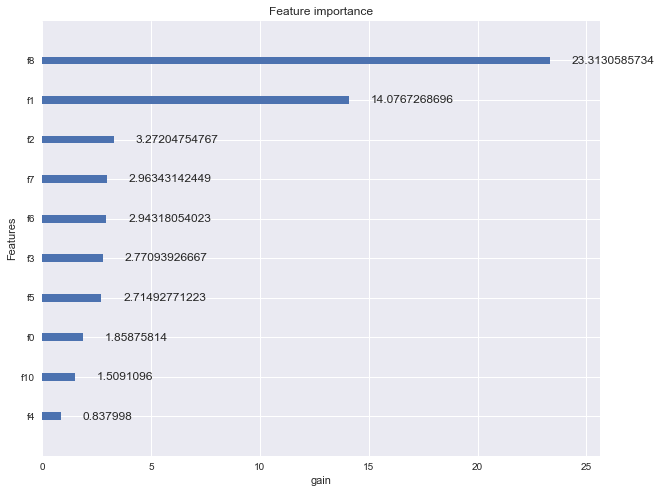

In [228]:
import xgboost as xgb
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(bst, importance_type='gain', xlabel='gain', ax=ax)
plt.show()

##### ~76% of X['Ticket'] is a unique value... so what importance does it have? Maybe it is overfitting the model... 
##### -> I can remove X['Ticket'] and tune hyperparameters with and without GridSearchCV/RandomizedSearchCV, but that is computationally expensive so I'll leave it in there for now...

##### GBM did the best on the train and test set and had the best standard deviation, so I'll focus on that. Also, knowing that SVM requires more tuning and does better on smaller datasets gives me reason to focus on SVM early on.

In [229]:
bst_predictions = pd.concat([pd.Series(bst_pred, index=y_test.index, name='Predictions'), y_test], axis=1)

#gbm_predictions.loc[ada_predictions['Predictions'] == 1]
bst_predictions.head()

,Predictions,Survived
288,0,1
869,1,1
182,0,0
684,0,0
599,0,1


In [230]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import validation_curve

cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=0)

##### Look at the validation_curve for number of trees to help parameter tuning in XGB, GBM, and SVM

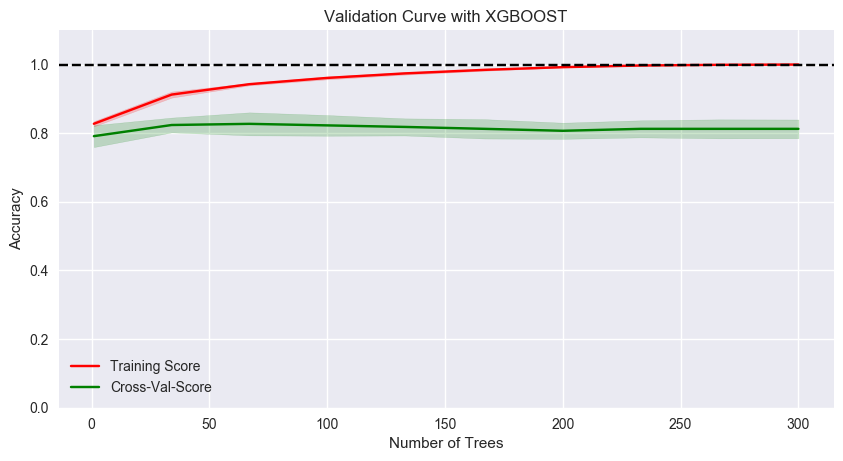

Best CV Result:  0.827189996975 67


In [231]:
default_params = {'objective':'binary:logistic',
                  'learning_rate': .3,
                  'silent': 1.0}

n_estimators_range = np.linspace(1,300,10).astype('int')

train_scores, test_scores = validation_curve(estimator=XGBClassifier(**default_params),
                                             X=X, y=y,
                                             param_name='n_estimators',
                                             param_range = n_estimators_range,
                                             cv=cv,
                                             n_jobs=-1,
                                             scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10,5), dpi=100)

plt.title('Validation Curve with XGBOOST')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)

plt.plot(n_estimators_range, train_scores_mean, label='Training Score', color='r')
plt.plot(n_estimators_range, test_scores_mean, label='Cross-Val-Score', color='g')

plt.fill_between(n_estimators_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=.2, color='r')
plt.fill_between(n_estimators_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=.2, color='g')

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc='best')
plt.show()

i = np.argmax(test_scores_mean)
print 'Best CV Result: ', test_scores_mean[i], n_estimators_range[i]

##### At 67 trees we reach max performance in XGB, so no need to tune that further. The training score keeps going up but the validation doesn't. 
##### -> Let's do the same for GBM

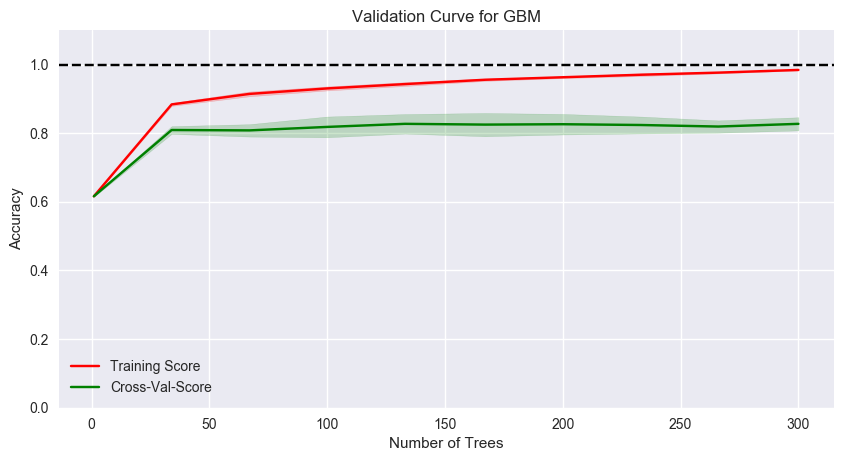

Best CV Result:  0.827221595106 133


In [232]:
n_estimators_range = np.linspace(1,300,10).astype('int')

train_scores, test_scores = validation_curve(estimator=GradientBoostingClassifier(),
                                             X=X, y=y,
                                             param_name='n_estimators',
                                             param_range = n_estimators_range,
                                             cv=cv,
                                             n_jobs=-1,
                                             scoring='accuracy')



train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10,5), dpi=100)

plt.title('Validation Curve for GBM')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)

plt.plot(n_estimators_range, train_scores_mean, label='Training Score', color='r')
plt.plot(n_estimators_range, test_scores_mean, label='Cross-Val-Score', color='g')

plt.fill_between(n_estimators_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=.2, color='r')
plt.fill_between(n_estimators_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=.2, color='g')

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc='best')
plt.show()

i = np.argmax(test_scores_mean)
print 'Best CV Result: ', test_scores_mean[i], n_estimators_range[i]

##### For GBM the max performance is at 300, but we can see that after about ~37 trees the validation performance flattens while the training score keeps increasing. This is a symptom for overfitting, so let's stick to ~37 trees.

##### Tune XGB using RandomizedSearchCV

In [233]:
param_dist = {'max_depth': [1, 5, 9],
              'learning_rate': np.linspace(1e-16, 1, 5),
              'n_estimators': [5, 35],
              'booster': ['gbtree', 'gblinear', 'dart'],
              'min_child_weight': [1,5,9],
              'subsample':[i/100.0 for i in range(50,100,10)],
              'colsample_bytree':[i/100.0 for i in range(50,100,5)],
              'reg_alpha':[.0001, .001, .1, 1, 10, 100],
              'reg_lambda':[.0001, .001, .1, 1, 10, 100],
              'scale_pos_weight': [0, .1, .25, .5, .75, 1],
              'gamma': [i/10.0 for i in range(0,11,2)]}

params_fixed = {'objective': 'binary:logistic', 'silent': 1}

In [234]:
# Calculate how long this will take to run

(len([i/10.0 for i in range(0,11,2)]) * len([-1,-.7,-.3, -.1, 0, .1, .3, .7, 1]) *
len([.0001, .001, .1, 1, 10, 100]) * len([.0001, .001, 0.1, 1, 10, 100]) *
len([i/100.0 for i in range(50,110,10)]) * len([i/100.0 for i in range(50,110,5)]) *
len([1,5,9]) * len(['gbtree', 'gblinear', 'dart']) * len([5, 35]) *
len(np.linspace(1e-16, 1, 5)) * len([1, 5, 9]))

37791360

##### The code below will take ~1.5 hours to run on a CPU

In [235]:
from sklearn.model_selection import RandomizedSearchCV

xgb_rs = RandomizedSearchCV(XGBClassifier(**params_fixed),
                      param_distributions=param_dist,
                      cv=5,
                      scoring='accuracy',
                      n_iter=10000).fit(X, y)

In [236]:
xgb_rs.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.85,
 'gamma': 0.8,
 'learning_rate': 0.5,
 'max_depth': 5,
 'min_child_weight': 9,
 'n_estimators': 35,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.9}

In [237]:
xgb_rs = XGBClassifier(**xgb_rs.best_params_).fit(X_train, y_train)

accuracy_score(xgb_rs.predict(X_train), y_train), accuracy_score(xgb_rs.predict(X_test), y_test)

(0.90119760479041922, 0.79372197309417036)

In [238]:
print pd.Series(xgb_rs.predict(X_test)).value_counts() 
print y_test.value_counts()

0    161
1     62
dtype: int64
0    137
1     86
Name: Survived, dtype: int64


In [239]:
# predictions

xgb_pred = pd.concat([pd.DataFrame(xgb_rs.predict(X_test), 
                        columns=['Predictions'], index=y_test.index), 
           y_test], axis=1)

xgb_pred

,Predictions,Survived
288,0,1
869,0,1
182,0,0
684,0,0
599,0,1
233,0,1
128,0,1
864,0,0
42,0,0
391,0,1


##### Tune GBM using GridSearchCV 
##### -> The below code will take ~7 hours to run on my CPU

In [240]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'n_estimators' : [50],
               'max_depth' : range(3,16,2),
               'min_samples_split' : range(200,2100,300),
               'min_samples_leaf' : range(30,70,10),
               'max_features' : range(7, len(X.columns), 2),
               'subsample': np.arange(.6,.9,.05),
               'learning_rate' : np.arange(.001, 1, .05)}

gs_gbm = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=5)

gs_gbm.fit(X_train_scaled, y_train)
gs_gbm

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [7, 9], 'learning_rate': array([ 0.001,  0.051,  0.101,  0.151,  0.201,  0.251,  0.301,  0.351,
        0.401,  0.451,  0.501,  0.551,  0.601,  0.651,  0.701,  0.751,
        0.801,  0.851,  0.901,  0.951]), 'min_samples_leaf': [30, 40, 50, 60], 'n_estimators': [50], 'subsample': array([ 0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ]), 'min_samples_split': [200, 500, 800, 1100, 1400, 170

In [241]:
'Best Params: ', gs_gbm.best_params_, 'Best Score: ', gs_gbm.best_score_

('Best Params: ',
 {'learning_rate': 0.30100000000000005,
  'max_depth': 7,
  'max_features': 9,
  'min_samples_leaf': 30,
  'min_samples_split': 200,
  'n_estimators': 50,
  'subsample': 0.8500000000000002},
 'Best Score: ',
 0.8413173652694611)

In [242]:
from sklearn.metrics import classification_report, roc_auc_score

gbm_best = gbm.set_params(**gs_gbm.best_params_).fit(X_train, y_train)
gbm_best_pred = gbm_best.predict(X_test)

print classification_report(gbm_best_pred, y_test)
print 'Accuracy: ', accuracy_score(gbm_best_pred, y_test)
print 'ROC AUC: ', roc_auc_score(gbm_best_pred, y_test)


             precision    recall  f1-score   support

          0       0.90      0.81      0.85       152
          1       0.66      0.80      0.73        71

avg / total       0.82      0.81      0.81       223

Accuracy:  0.807174887892
ROC AUC:  0.806013713862


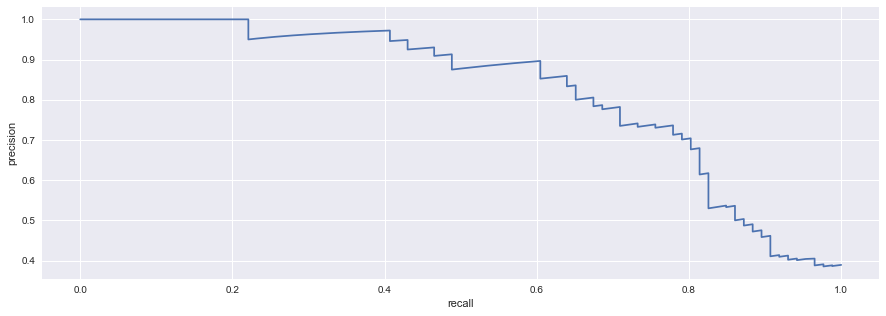

In [243]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

y_score_gbm = gbm_best.decision_function(X_test)

precision, recall, threshold = precision_recall_curve(y_test, y_score_gbm)

fig = plt.gcf()
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
fig.set_size_inches((15, 5))
plt.show()

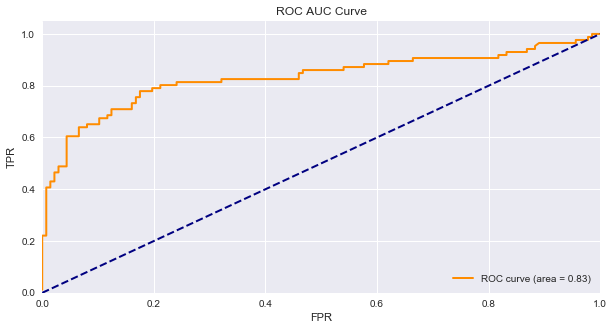

In [244]:
from sklearn.metrics import roc_curve, auc

y_score = gbm_best.decision_function(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.subplots(figsize=(10, 5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

In [245]:
len(X['Ticket'].unique()), len(X)

(681, 891)

##### Lets take a look at the actual vs predictions

In [246]:
pd.concat([pd.DataFrame(gbm_best_pred, columns=['Predictions'], index=y_test.index), y_test], axis=1) # Test predictions

,Predictions,Survived
288,0,1
869,0,1
182,0,0
684,0,0
599,1,1
233,0,1
128,0,1
864,0,0
42,0,0
391,0,1


### Let's start tuning the SVM classifier and see if that outperforms GBM
##### -> This time I will use RandomizedSearchCV since SVM is even more computationally expensive than GBM

In [247]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

C_range = 10. ** np.arange(-3, 8)
gamma_range = np.logspace(-9, 3, 13)
param_dist = dict(gamma=gamma_range, C=C_range)

rs_svc = RandomizedSearchCV(SVC(), param_distributions=param_dist, n_iter=30, 
                            scoring='accuracy', refit=True, n_jobs=-1, 
                            cv=5, random_state=0).fit(X_train_scaled, y_train)

rs_svc.best_params_

{'C': 1000.0, 'gamma': 0.001}

In [248]:
svc_best = SVC().set_params(**rs_svc.best_params_).fit(X_train_scaled, y_train)

##### Let's try it with GridSearchCV

In [249]:
param_grid = dict(gamma=gamma_range, C=C_range)

gs_svc = GridSearchCV(SVC(), param_grid, scoring='accuracy', 
                      cv=5, n_jobs=-1).fit(X, y)

gs_svc.best_params_

{'C': 1000000.0, 'gamma': 9.9999999999999995e-08}

In [250]:
svc_best_pred = svc_best.predict(X_test_scaled)
accuracy_score(svc_best_pred, y_test)

0.81165919282511212

##### It turns out both gridsearch and randomizedsearch have the same best hyperparameters C and Gamma

### Check train and test scores for GBM and SVC - check for high bias / high variance

In [251]:
print 'GBM Train Score: ', accuracy_score(gbm_best.predict(X_train), y_train)
print 'GBM Test Score: ', accuracy_score(gbm_best_pred, y_test)

print 'SVM Train Score: ', accuracy_score(svc_best.predict(X_train_scaled), y_train)
print 'SVM Test Score: ', accuracy_score(svc_best_pred, y_test)

GBM Train Score:  0.920658682635
GBM Test Score:  0.807174887892
SVM Train Score:  0.833832335329
SVM Test Score:  0.811659192825


##### -> bias/variance  tradeoff seems okay...but I think both models can fit the train set better... i.e these models are suffering from slightly high bias
###### -> A couple ways to fix this would be to hand engineer some new features, 
######    and/or possibly approach this with a DNN, with multiple hidden layers and hidden units in each layer... I'll save this for another time :)

### Let's take a look at some evaluation metrics to see how these classifiers are doing

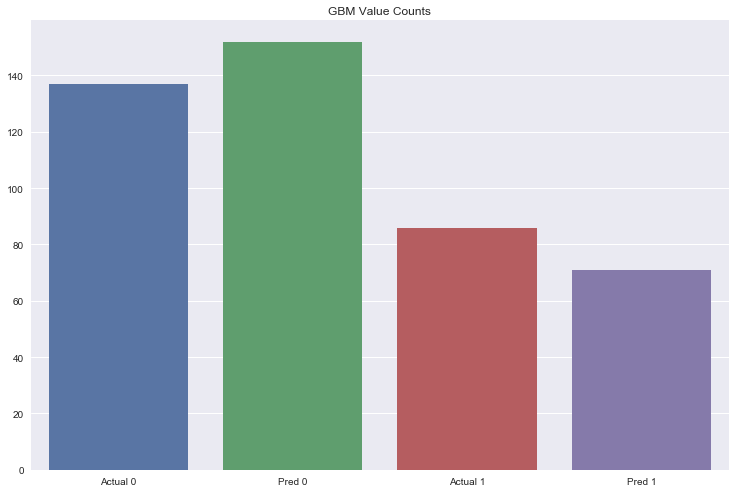

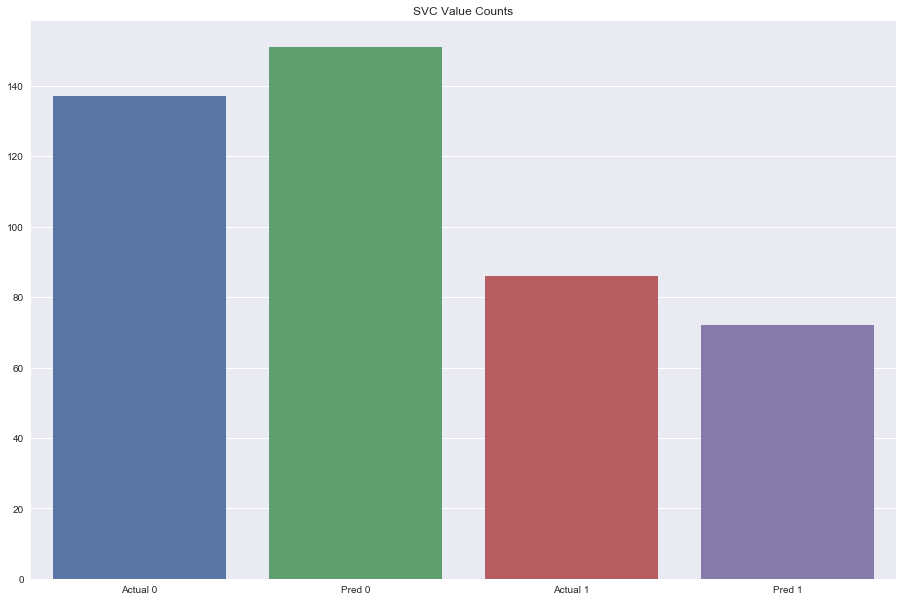

In [252]:
import seaborn as sns

sns.barplot(x=['Actual 0', 'Pred 0', 'Actual 1', 'Pred 1'], 
            y=[y_test.value_counts()[0], pd.Series(gbm_best_pred).value_counts()[0],
               y_test.value_counts()[1], pd.Series(gbm_best_pred).value_counts()[1]])
sns.set(rc={'figure.figsize':(15.5, 10.27)})
plt.title('GBM Value Counts')
plt.show()



sns.barplot(x=['Actual 0', 'Pred 0', 'Actual 1', 'Pred 1'], 
            y=[y_test.value_counts()[0], pd.Series(svc_best_pred).value_counts()[0],
               y_test.value_counts()[1], pd.Series(svc_best_pred).value_counts()[1]])
sns.set(rc={'figure.figsize':(12.5, 8.27)})
plt.title('SVC Value Counts')
plt.show()

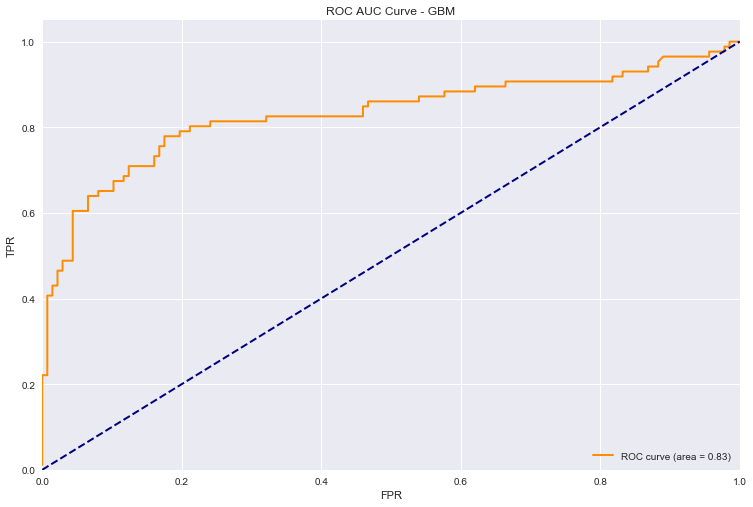

In [253]:
from sklearn.metrics import roc_curve, auc

y_score_gbm = gbm_best.decision_function(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_score_gbm)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC Curve - GBM')
plt.legend(loc="lower right")
plt.show()

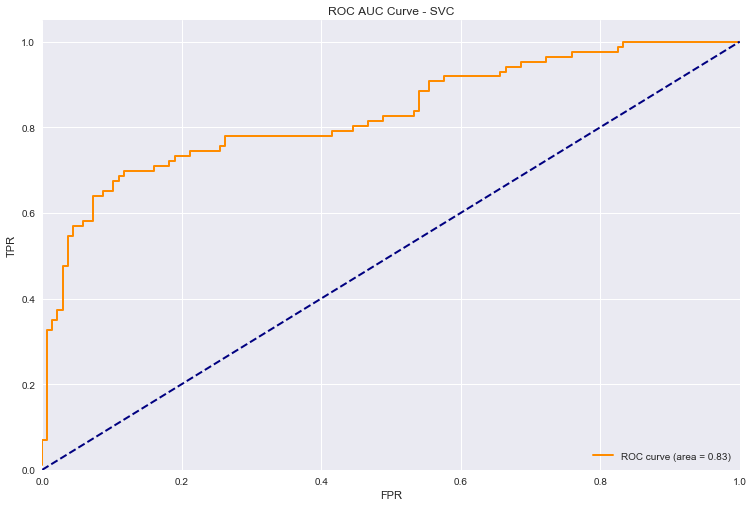

In [254]:
from sklearn.metrics import roc_curve, auc

y_score_svc = svc_best.decision_function(X_test_scaled)

fpr, tpr, threshold = roc_curve(y_test, y_score_svc)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC Curve - SVC')
plt.legend(loc="lower right")
plt.show()

In [255]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, gbm_best_pred).ravel()

tn, fp, fn, tp

(123, 14, 29, 57)

In [256]:
tn, fp, fn, tp = confusion_matrix(y_test, svc_best_pred).ravel()

tn, fp, fn, tp

(123, 14, 28, 58)

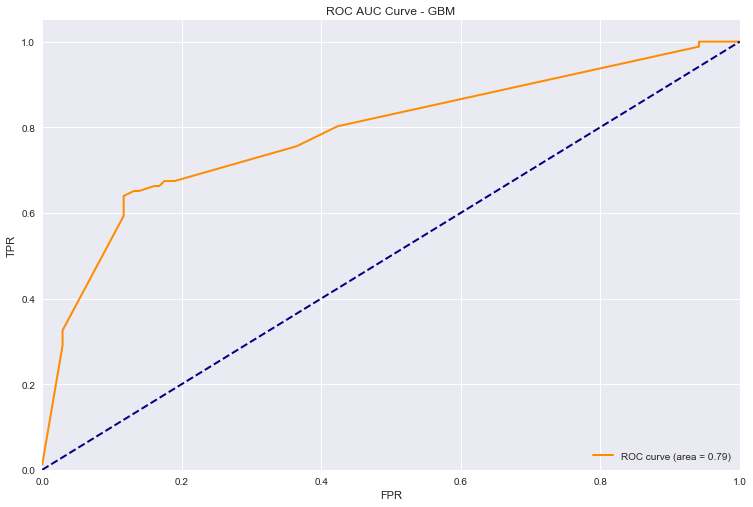

In [257]:
from sklearn.metrics import roc_curve, auc

y_score_gbm = gbm_best.decision_function(X_test_scaled)

fpr, tpr, threshold = roc_curve(y_test, y_score_gbm)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC Curve - GBM')
plt.legend(loc="lower right")
plt.show()

In [258]:
pd.DataFrame((gbm_best.predict(df_test)), columns=['Survived']).set_index(df_test.PassengerId).to_csv('/Users/melgazar9/Desktop/Titanic_gbm_predictions.csv')

In [259]:
df_test_scaled = scaler.transform(df_test)

pd.DataFrame((svc_best.predict(df_test_scaled)), columns=['Survived']).set_index(df_test.PassengerId).to_csv('/Users/melgazar9/Desktop/Titanic_svm_predictions.csv')

In [260]:
pd.DataFrame((gbm_best.predict(df_test)), columns=['Survived']).set_index(df_test.PassengerId)

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


In [261]:
pd.DataFrame((svc_best.predict(df_test_scaled)), columns=['Survived']).set_index(df_test.PassengerId)

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


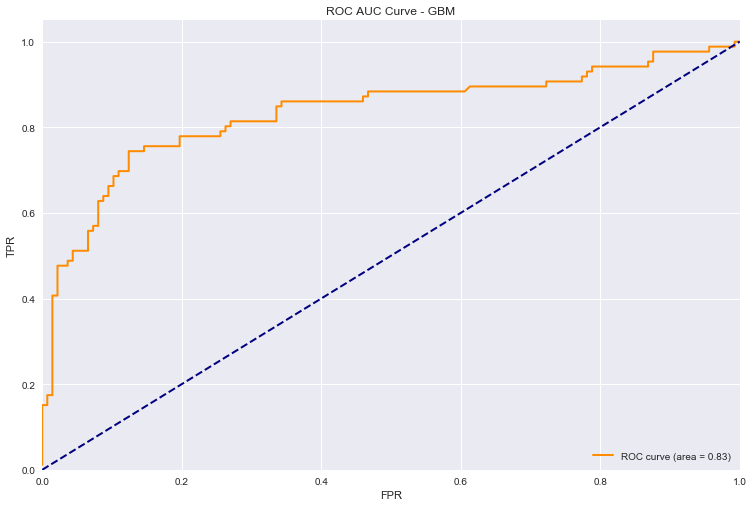

In [262]:
y_score_xgb = xgb_rs.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, y_score_xgb)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC Curve - GBM')
plt.legend(loc="lower right")
plt.show()

In [263]:
df_test_pred_gbm = gbm_best.fit(X_train_scaled, y_train).predict(df_test_scaled)

In [264]:
df_test_pred_gbm = pd.DataFrame(df_test_pred_gbm, columns=['Survived']).set_index(df_test['PassengerId'])

In [265]:
df_test_pred_gbm.to_csv('/Users/melgazar9/Desktop/TitanicSolutionsGBM.csv')

In [266]:
pd.DataFrame((xgb_rs.predict(df_test)), columns=['Survived']).set_index(df_test.PassengerId).to_csv('/Users/melgazar9/Desktop/Titanic_XGB_predictions.csv')

##### Do a final randomizedsearch for xgb and put the predictions into a csv for Kaggle submission

In [267]:
param_dist = {'max_depth': [1, 5, 9],
              'learning_rate': np.linspace(1e-16, 1, 5),
              'n_estimators': [5, 35],
              'booster': ['gbtree', 'gblinear', 'dart'],
              'min_child_weight': [1,5,9],
              'subsample':[i/100.0 for i in range(50,100,10)],
              'colsample_bytree':[i/100.0 for i in range(50,100,5)],
              'reg_alpha':[.0001, .001, .1, 1, 10, 100],
              'reg_lambda':[.0001, .001, .1, 1, 10, 100],
              'scale_pos_weight': [0, .1, .25, .5, .75, 1],
              'gamma': [i/10.0 for i in range(0,11,2)]}

params_fixed = {'objective': 'binary:logistic', 'silent': 1}

xgb_rs = RandomizedSearchCV(XGBClassifier(**params_fixed),
                      param_distributions=param_dist,
                      cv=5,
                      scoring='accuracy',
                      n_iter=10000).fit(X_train, y_train)

In [268]:
pd.DataFrame((xgb_rs.predict(df_test)), columns=['Survived']).set_index(df_test.PassengerId).to_csv('/Users/melgazar9/Desktop/Titanic_XGB_predictions.csv')

### Score is .80382 => 1192 on the leaderboard as of today